# Sections

Frameworks:

* PyTorch first pass
    * `Model` with `forward` method.
    * Manual training loop
* PyTorch second pass
    * `Model` with `forward` method.
    * `Trainer` class that takes in:
        * `Model`
        * `Optimizer`
        * `_Loss`

Models:

* Boston dataset (used for testing)
* MNIST Conv net
* LSTM layer

In [173]:
# imports
from typing import Tuple, List
from collections import deque

import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim import Optimizer

import numpy as np
from torch import Tensor

import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.loss import _Loss

from lincoln.utils import permute_data, assert_dim

from lincoln.pytorch.model import PyTorchModel
from lincoln.pytorch.train import PyTorchTrainer
from lincoln.pytorch.preprocessor import ConvNetPreprocessor

torch.manual_seed(20190325);

In [174]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Defining PyTorch Layers

In [175]:
class PyTorchLayer(nn.Module):

    def __init__(self) -> None:
        super().__init__()

    def forward(self, x: Tensor,
                inference: bool = False) -> Tensor:
        raise NotImplementedError()
        
def inference_mode(m: nn.Module):
    m.eval()


In [176]:
class DenseLayer(PyTorchLayer):
    def __init__(self,
                 input_size: int,
                 neurons: int,
                 dropout: float = 1.0,
                 activation: nn.Module = None) -> None:
        super().__init__()
        self.linear = nn.Linear(input_size, neurons)
        self.activation = activation
        if dropout < 1.0:
            self.dropout = nn.Dropout(1 - dropout)


    def forward(self, x: Tensor,
                inference: bool = False) -> Tensor:
        if inference:
            self.apply(inference_mode)
        
        x = self.linear(x) # does weight multiplication + bias
        if self.activation:
            x = self.activation(x)
        if hasattr(self, "dropout"):
            x = self.dropout(x)
            
        return x

## MNIST Data

In [223]:
from torchvision.datasets import MNIST
mnist_trainset = MNIST(root="../exploratory/data/", train=True, download=True, transform=None)
mnist_testset = MNIST(root="../exploratory/data/", train=False, download=True, transform=None)

In [225]:
mnist_train = mnist_trainset.train_data.type(torch.float32).unsqueeze(3) / 255.0
mnist_test = mnist_testset.test_data.type(torch.float32).unsqueeze(3) / 255.0

In [226]:
mnist_train.max(), mnist_train.min(), mnist_train.std()

(tensor(1.), tensor(0.), tensor(0.3081))

## Testing `transform`

In [230]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Normalize((1.0), (0.5))
])


mnist_trainset = MNIST(root="../exploratory/data/", train=True, transform=transform)
mnist_train = mnist_trainset.train_data.type(torch.float32).unsqueeze(3) / 255.0
mnist_train.max(), mnist_train.min(), mnist_train.std()

(tensor(1.), tensor(0.), tensor(0.3081))

In [254]:
from torch.utils.data import DataLoader

img_transform = transforms.Compose([
    transforms.ToTensor()
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = MNIST("../exploratory/data/", transform=img_transform)
dataloader = DataLoader(dataset, batch_size=60, shuffle=True)

for data in dataloader:
    img, _ = data
    break

img.shape, img.min(), img.max(), img.std()

(torch.Size([60, 1, 28, 28]), tensor(0.), tensor(1.), tensor(0.3112))

In [258]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5, 0.5), (0.5, 0.5, 0.5, 0.5))
])

dataset = MNIST("../exploratory/data/", transform=img_transform)
dataloader = DataLoader(dataset, batch_size=60, shuffle=True)

for data in dataloader:
    img, _ = data
    break

img.shape, img.min(), img.max(), img.std()

(torch.Size([60, 1, 28, 28]), tensor(-1.), tensor(1.), tensor(0.6199))

In [261]:
type(dataset), type(dataloader)

(torchvision.datasets.mnist.MNIST, torch.utils.data.dataloader.DataLoader)

In [256]:
type((0.5,))

tuple

In [267]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1305,), (0.3081,))
])

dataset = MNIST("../exploratory/data/", transform=img_transform)
dataloader = DataLoader(dataset, batch_size=60, shuffle=True)

for data in dataloader:
    img, _ = data
    break

img.shape, img.min(), img.max(), img.std()

(torch.Size([60, 1, 28, 28]), tensor(-0.4236), tensor(2.8221), tensor(1.0023))

Should technically modify `Trainer` to use `DataLoader`.

In [179]:
class ConvLayer(PyTorchLayer):
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 filter_size: int = 5,
                 activation: nn.Module = None,
                 dropout: float = 1.0,
                 flatten: bool = False) -> None:
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, filter_size, 
                              padding=filter_size // 2)
        self.activation = activation
        self.flatten = flatten
        if dropout < 1.0:
            self.dropout = nn.Dropout(1 - dropout)

    def forward(self, x: Tensor) -> Tensor:
            
        x = self.conv(x)
        if self.activation:
            x = self.activation(x)
        if self.flatten:
            x = x.view(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3])
        if hasattr(self, "dropout"):
            x = self.dropout(x)            
            
        return x

In [265]:
X_train, X_test = mnist_train.permute(0, 3, 1, 2), mnist_test.permute(0, 3, 1, 2)

In [266]:
X_train.mean(), X_train.std()

(tensor(0.1305), tensor(0.3081))

In [264]:
X_train, X_test = X_train - X_train.mean(), X_test - X_train.mean()
X_train, X_test = X_train / X_train.std(), X_test / X_train.std()

## Unsupervised Learning

In [182]:
class Autoencoder(PyTorchModel):
    def __init__(self,
                 hidden_dim: int = 28):
        super(Autoencoder, self).__init__()
        self.conv1 = ConvLayer(1, 14, 5, activation=nn.Tanh())
        self.conv2 = ConvLayer(14, 7, 5, activation=nn.Tanh(), flatten=True)
        
        self.dense1 = DenseLayer(7 * 28 * 28, hidden_dim, activation=nn.Tanh())
        self.dense2 = DenseLayer(hidden_dim, 7 * 28 * 28, activation=nn.Tanh())
        
        self.conv3 = ConvLayer(7, 14, 5, activation=nn.Tanh()) 
        self.conv4 = ConvLayer(14, 1, 5, activation=nn.Tanh())         

    def forward(self, x: Tensor) -> Tensor:
        assert_dim(x, 4)
            
        x = self.conv1(x)
        x = self.conv2(x)
        
        encoding = self.dense1(x)
        
        x = self.dense2(encoding)
        
        
        
        x = self.conv3(x)
        x = self.conv4(x)

        return x, encoding

## Autoencoder using separate `Encoder` and `Decoder` classes

In [183]:
class Encoder(PyTorchModel):
    def __init__(self,
                 hidden_dim: int = 28):
        super(Encoder, self).__init__()
        self.conv1 = ConvLayer(1, 14, activation=nn.Tanh())
        self.conv2 = ConvLayer(14, 7, activation=nn.Tanh(), flatten=True)
        
        self.dense1 = DenseLayer(7 * 28 * 28, hidden_dim, activation=nn.Tanh())

    def forward(self, x: Tensor) -> Tensor:
        assert_dim(x, 4)
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dense1(x)        

        return x

In [184]:
class Decoder(PyTorchModel):
    def __init__(self,
                 hidden_dim: int = 28):
        super(Decoder, self).__init__()
        self.dense1 = DenseLayer(hidden_dim, 7 * 28 * 28, activation=nn.Tanh())
        
        self.conv1 = ConvLayer(7, 14, activation=nn.Tanh()) 
        self.conv2 = ConvLayer(14, 1, activation=nn.Tanh())    

    def forward(self, x: Tensor) -> Tensor:
        assert_dim(x, 2)
        
        x = self.dense1(x)
        
        x = x.view(-1, 7, 28, 28)
        x = self.conv1(x)
        x = self.conv2(x)        

        return x

In [185]:
class Autoencoder(PyTorchModel):
    def __init__(self,
                 hidden_dim: int = 28):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(hidden_dim)
        
        self.decoder = Decoder(hidden_dim)

    def forward(self, x: Tensor) -> Tensor:
        assert_dim(x, 4)

        encoding = self.encoder(x)
        x = self.decoder(encoding)

        return x, encoding

In [186]:
X_train_auto = (X_train - X_train.min()) / (X_train.max() - X_train.min()) * 2 - 1
X_test_auto = (X_test - X_train.min()) / (X_train.max() - X_train.min()) * 2 - 1

In [187]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [188]:
trainer = PyTorchTrainer(model, optimizer, criterion)

trainer.fit(X_train_auto, X_train_auto, 
            X_test_auto, X_test_auto,
            batch_size=60,
            epochs=1)

The loss after 0 epochs was 0.06898786127567291


In [189]:
reconstructed_images, image_representations = model(X_test_auto)

In [190]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [191]:
def display_image(ax,
    t: Tensor):
    n = t.detach().numpy()
    ax.imshow(n.reshape(28, 28))

In [192]:
a = np.random.randint(0, 10000)

1618

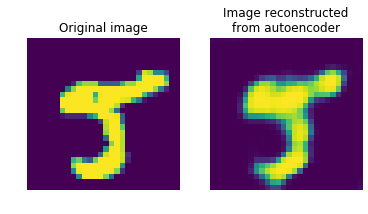

In [193]:
f, axarr = plt.subplots(1,2)
display_image(axarr[0], X_test[a])
display_image(axarr[1], reconstructed_images[a])

axarr[0].set_title("Original image")
axarr[1].set_title("Image reconstructed\nfrom autoencoder")

axarr[0].axis('off')
axarr[1].axis('off');

f.savefig("../../01_deep-learning-from-scratch/images/07_pytorch/03_autoencoder_example_image.png")

## Testing decoder

In [204]:
test_encodings = np.random.uniform(low=-1.0, high=1.0, size=(5, 28))

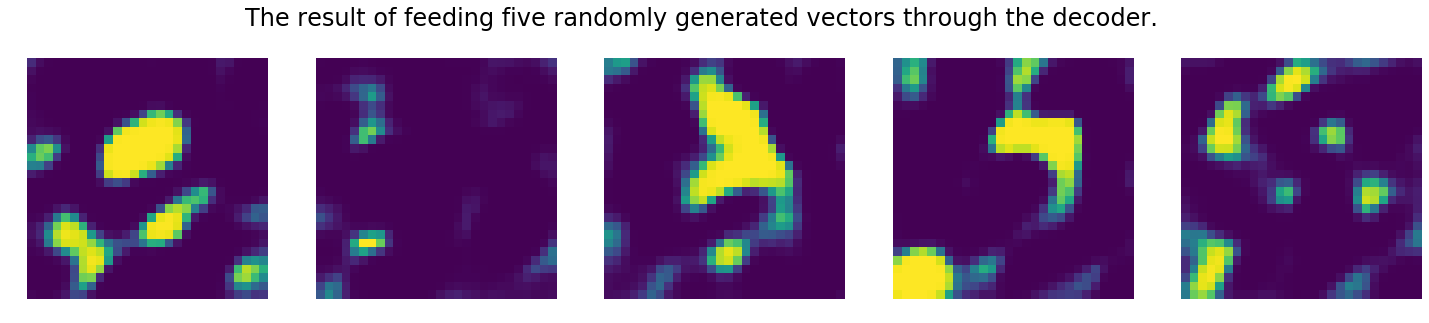

In [217]:
test_imgs = model.decoder(Tensor(test_encodings))
f2, axarr2 = plt.subplots(1,5, figsize=(25,5))
for i in range(5):
    display_image(axarr2[i], test_imgs[i])
    axarr2[i].axis('off')
f2.suptitle("The result of feeding five randomly generated vectors through the decoder.",
            fontsize=24)
f2.savefig("../../01_deep-learning-from-scratch/images/07_pytorch/04_autoencoder_random.png")

#### TSNE viz

In [194]:
from sklearn.manifold import TSNE
tsne_result = TSNE(n_components=2, random_state=20190405).fit_transform(
    image_representations.detach().numpy())

KeyboardInterrupt: 

In [ ]:
import pandas as pd
tsne_df = pd.DataFrame({'tsne_dim_1': tsne_result[:,0], 
              'tsne_dim_2': tsne_result[:,1],
              'category': mnist_testset.test_labels})

groups = tsne_df.groupby('category')

# Plot
fig, ax = plt.subplots(figsize=(25,25))
ax.set_title('''10000 observations from MNIST test set, colored by their actual digit. 
Locations are the result of reducing the 28 values from hidden layer of the convolutional
autoencoder - trained without labels - down to two dimensions using t-SNE.''')
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.scatter(group['tsne_dim_1'], group['tsne_dim_2'], marker='o', label=name)
ax.legend()
fig.savefig("../../01_deep-learning-from-scratch/images/07_pytorch/00_tsne.png")

## Autoencoder with hidden dimension 2

In [217]:
model2 = Autoencoder2(hidden_dim=2)
criterion = nn.MSELoss()
optimizer = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)

trainer = PyTorchTrainer(model2, optimizer, criterion)

trainer.fit(X_train_auto, X_train_auto, 
            X_test_auto, X_test_auto,
            epochs=1,
            eval_every=1,
            batch_size=60,
            final_lr_exp = 0.001)

The loss after 0 epochs was 0.24263836443424225


In [218]:
reconstructed_images, image_representations = model2(X_test_auto)

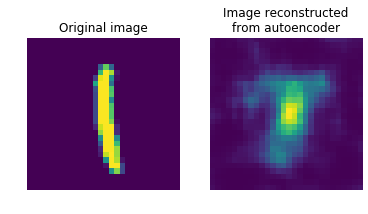

In [221]:
f, axarr = plt.subplots(1,2)
display_image(axarr[0], X_test[3765])
display_image(axarr[1], reconstructed_images[3765])

axarr[0].set_title("Original image")
axarr[1].set_title("Image reconstructed\nfrom autoencoder")

axarr[0].axis('off')
axarr[1].axis('off');

f.savefig("../../01_deep-learning-from-scratch/images/07_pytorch/03_autoencoder_example_image.png")

## Testing

In [73]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [74]:
model3 = autoencoder()
criterion = nn.MSELoss()
optimizer = optim.SGD(model3.parameters(), lr=0.01, momentum=0.9)

trainer = PyTorchTrainer(model3, optimizer, criterion)

trainer.fit(X_train_auto, X_tirain_auto, 
            X_test_auto, X_test_auto,
            epochs=1,
            eval_every=1,
            batch_size=60,
            final_lr_exp = 0.001)

KeyboardInterrupt: 

In [77]:
model3.encoder(X_test_auto).shape

torch.Size([10000, 8, 2, 2])